# Assignment 1 2AMM10 2023-2024

## Group: [Group ]
### Member 1: [Jasper Wilfling]
### Member 2: [Justin Habets]
### Member 3: [Thijmen Adriaansen]

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler
from itertools import combinations
from sklearn.metrics import balanced_accuracy_score
from collections import Counter
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


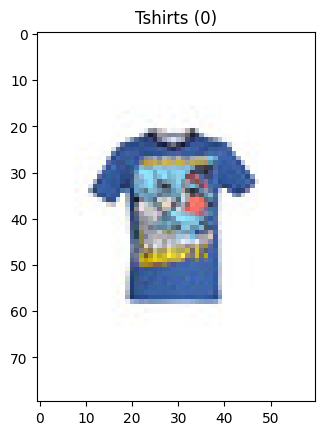

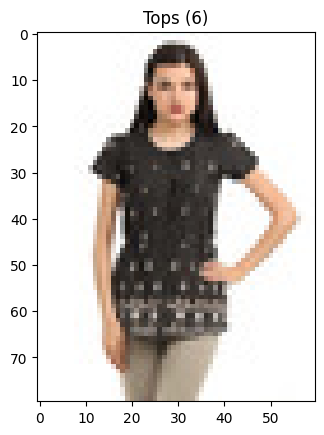

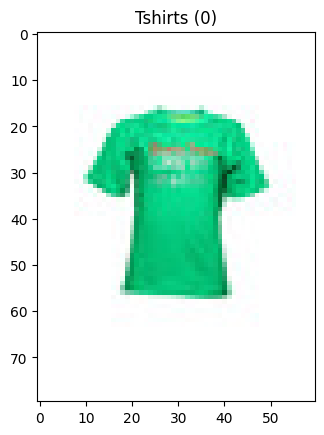

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3) # randomly select 3 indices

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((80, 60)),  # Ensure consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [7]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self, num_classes=39):
        super(FashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 30x40
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x20
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x10
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 10, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)


In [8]:
# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = FashionCNN(num_classes=39).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Average Loss: {running_loss / len(train_loader):.4f}")

torch.save(model.state_dict(), "task_1.pth")

Using device: cuda


Epoch 1/10: 100%|██████████| 562/562 [01:15<00:00,  7.43it/s, loss=0.565]


Epoch 1, Average Loss: 0.9611


Epoch 2/10: 100%|██████████| 562/562 [00:41<00:00, 13.59it/s, loss=0.515]


Epoch 2, Average Loss: 0.5031


Epoch 3/10: 100%|██████████| 562/562 [00:36<00:00, 15.48it/s, loss=0.322]


Epoch 3, Average Loss: 0.3974


Epoch 4/10: 100%|██████████| 562/562 [00:36<00:00, 15.36it/s, loss=0.48] 


Epoch 4, Average Loss: 0.3314


Epoch 5/10: 100%|██████████| 562/562 [00:36<00:00, 15.61it/s, loss=0.178] 


Epoch 5, Average Loss: 0.2772


Epoch 6/10: 100%|██████████| 562/562 [00:35<00:00, 15.77it/s, loss=0.375] 


Epoch 6, Average Loss: 0.2369


Epoch 7/10: 100%|██████████| 562/562 [00:35<00:00, 15.85it/s, loss=0.0615]


Epoch 7, Average Loss: 0.1989


Epoch 8/10: 100%|██████████| 562/562 [00:36<00:00, 15.53it/s, loss=0.146] 


Epoch 8, Average Loss: 0.1706


Epoch 9/10: 100%|██████████| 562/562 [00:37<00:00, 14.85it/s, loss=0.176] 


Epoch 9, Average Loss: 0.1488


Epoch 10/10: 100%|██████████| 562/562 [00:34<00:00, 16.07it/s, loss=0.0364]

Epoch 10, Average Loss: 0.1270


In [9]:
# Evaluation on test dataset
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            for label, pred in zip(labels, preds):
                class_total[label.item()] += 1
                if pred.item() == label.item():
                    class_correct[label.item()] += 1

    # Accuracy
    accuracy = correct / total

    # Balanced accuracy
    all_classes = list(class_total.keys())
    balanced_acc = sum(class_correct[c] / class_total[c] for c in all_classes) / len(all_classes)

    return accuracy, balanced_acc

accuracy, balanced_acc = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Balanced Accuracy: {balanced_acc:.4f}")


Test Accuracy: 0.8848
Test Balanced Accuracy: 0.8336


## Task 2

In [10]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [8]:
class EmbeddingFashionCNN(nn.Module):
    def __init__(self, embedding_dim=39):
        super(EmbeddingFashionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 30x40
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x20
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x10
        )
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 10, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, embedding_dim)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)  # L2 normalize embeddings
        return x

In [8]:
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(  np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [9]:
class RandomTripletSelector():
    """
    Select random negative  example for  each positive pair  to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [10]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate model and move to device
model = EmbeddingFashionCNN().to(device)

# Define loss function, optimizer, and learning rate scheduler
triplet_loss = TripletLoss(margin=1, triplet_selector=RandomTripletSelector()).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

# DataLoader setup using BalancedBatchSampler
train_batch_sampler = BalancedBatchSampler(train_dataset.targets, n_classes=10, n_samples=5)
train_loader = DataLoader(train_dataset, batch_sampler=train_batch_sampler)


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the train_loader with tqdm to show progress
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass: Get embeddings
        embeddings = model(images)

        # Compute triplet loss
        loss = triplet_loss(embeddings, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Step the scheduler using training loss
    scheduler.step(epoch_loss)

# Save the trained model
torch.save(model.state_dict(), "task_2.pth")

Epoch 1/10: 100%|██████████| 718/718 [00:44<00:00, 16.31it/s]


Epoch [1/10], Loss: 0.1967


Epoch 2/10: 100%|██████████| 718/718 [00:41<00:00, 17.25it/s]


Epoch [2/10], Loss: 0.1037


Epoch 3/10: 100%|██████████| 718/718 [00:50<00:00, 14.29it/s]


Epoch [3/10], Loss: 0.0895


Epoch 4/10: 100%|██████████| 718/718 [00:42<00:00, 16.98it/s]


Epoch [4/10], Loss: 0.0739


Epoch 5/10: 100%|██████████| 718/718 [00:41<00:00, 17.47it/s]


Epoch [5/10], Loss: 0.0654


Epoch 6/10: 100%|██████████| 718/718 [00:42<00:00, 16.92it/s]


Epoch [6/10], Loss: 0.0608


Epoch 7/10: 100%|██████████| 718/718 [00:54<00:00, 13.29it/s]


Epoch [7/10], Loss: 0.0541


Epoch 8/10: 100%|██████████| 718/718 [00:49<00:00, 14.42it/s]


Epoch [8/10], Loss: 0.0511


Epoch 9/10: 100%|██████████| 718/718 [00:49<00:00, 14.57it/s]


Epoch [9/10], Loss: 0.0537


Epoch 10/10: 100%|██████████| 718/718 [00:45<00:00, 15.62it/s]

Epoch [10/10], Loss: 0.0476


In [ ]:
#import model
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

def extract_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            embeddings = model(images)  # embeddings already normalized inside model
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)

    return all_embeddings, all_labels

def knn_classify(test_embeddings, support_embeddings, support_labels, k=5):
    """
    Classify test embeddings using k-NN with support embeddings and labels.
    """
    # Compute pairwise Euclidean distances: shape (N_test, N_support)
    distances = torch.cdist(test_embeddings, support_embeddings)

    preds = []
    for dist_vec in distances:
        knn_indices = dist_vec.topk(k, largest=False).indices  # Indices of k nearest neighbors
        knn_labels = support_labels[knn_indices]
        most_common = Counter(knn_labels.tolist()).most_common(1)[0][0]
        preds.append(most_common)

    return torch.tensor(preds)

In [17]:
support_loader_main_train = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader_main_test = DataLoader(main_test_dataset, batch_size=32, shuffle=False)

support_loader_main_support = DataLoader(main_support_dataset, batch_size=32, shuffle=False)
test_loader_main_test2 = DataLoader(main_test_dataset, batch_size=32, shuffle=False)

support_loader_new = DataLoader(new_support_dataset, batch_size=32, shuffle=False)
test_loader_new = DataLoader(new_test_dataset, batch_size=32, shuffle=False)

support_loader_mixed = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
test_loader_mixed = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

In [18]:
support_embeddings_main_train, support_labels_main_train = extract_embeddings(model, support_loader_main_train, device)
test_embeddings_main_test, test_labels_main_test = extract_embeddings(model, test_loader_main_test, device)

support_embeddings_main_support, support_labels_main_support = extract_embeddings(model, support_loader_main_support, device)
test_embeddings_main_test2, test_labels_main_test2 = extract_embeddings(model, test_loader_main_test2, device)

support_embeddings_new, support_labels_new = extract_embeddings(model, support_loader_new, device)
test_embeddings_new, test_labels_new = extract_embeddings(model, test_loader_new, device)

support_embeddings_mixed, support_labels_mixed = extract_embeddings(model, support_loader_mixed, device)
test_embeddings_mixed, test_labels_mixed = extract_embeddings(model, test_loader_mixed, device)

In [19]:
def evaluate_knn(support_embeddings, support_labels, test_embeddings, test_labels, k=5):
    predicted_labels = knn_classify(test_embeddings, support_embeddings, support_labels, k=k)

    accuracy = (predicted_labels == test_labels).float().mean().item()
    balanced_acc = balanced_accuracy_score(test_labels.numpy(), predicted_labels.numpy())

    return accuracy, balanced_acc


# Scenario 1: Main classes train -> Main classes test
acc1, bal_acc1 = evaluate_knn(support_embeddings_main_train, support_labels_main_train,
                             test_embeddings_main_test, test_labels_main_test)
print(f'Scenario 1 - Accuracy: {acc1:.4f} | Balanced Accuracy: {bal_acc1:.4f}')

# Scenario 2: Main classes support -> Main classes test
acc2, bal_acc2 = evaluate_knn(support_embeddings_main_support, support_labels_main_support,
                             test_embeddings_main_test2, test_labels_main_test2)
print(f'Scenario 2 - Accuracy: {acc2:.4f} | Balanced Accuracy: {bal_acc2:.4f}')

# Scenario 3: New classes support -> New classes test
acc3, bal_acc3 = evaluate_knn(support_embeddings_new, support_labels_new,
                             test_embeddings_new, test_labels_new)
print(f'Scenario 3 - Accuracy: {acc3:.4f} | Balanced Accuracy: {bal_acc3:.4f}')

# Scenario 4: Mixed support -> Mixed test
acc4, bal_acc4 = evaluate_knn(support_embeddings_mixed, support_labels_mixed,
                             test_embeddings_mixed, test_labels_mixed)
print(f'Scenario 4 - Accuracy: {acc4:.4f} | Balanced Accuracy: {bal_acc4:.4f}')

Scenario 1 - Accuracy: 0.7977 | Balanced Accuracy: 0.7488
Scenario 2 - Accuracy: 0.7747 | Balanced Accuracy: 0.7113
Scenario 3 - Accuracy: 0.6193 | Balanced Accuracy: 0.5876
Scenario 4 - Accuracy: 0.6046 | Balanced Accuracy: 0.5417


## Task 3

In [20]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload the model from the previous task
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

test_loader_mixed = DataLoader(merged_test_dataset, batch_size=len(merged_test_dataset), shuffle=False)
merged_support_loader = DataLoader(merged_support_dataset, batch_size=len(merged_support_dataset), shuffle=False)

error_rate_dict = {} #dict to store error rates per coverage rate value

# Extract embeddings for the test dataset
test_embeddings, test_labels = extract_embeddings(model, test_loader_mixed, device)

# Extract embeddings for the support dataset
support_embeddings, support_labels = extract_embeddings(model, merged_support_loader, device)

# Compute pairwise Euclidean distances: shape (N_test, N_support)
distances = torch.cdist(test_embeddings, support_embeddings)

# Iterate over distance thresholds
for distance_threshold in np.arange(0.01, 1.0, 0.01):
    # Calculate the error rate
    error_rate = 0
    coverage_rate = 0
    for i in range(len(test_labels)):
        # Get the indices of the 3 nearest neighbors
        knn_indices = distances[i].topk(3, largest=False).indices

        # Get the labels of the 3 nearest neighbors
        knn_labels = support_labels[knn_indices]
        predicted_labels = torch.mode(knn_labels).values

        # check if all 3 nearest neighbors are within the distance threshold
        if distances[i, knn_indices[0]] < distance_threshold and \
           distances[i, knn_indices[1]] < distance_threshold and \
           distances[i, knn_indices[2]] < distance_threshold:

            coverage_rate += 1

            # check if at least one of the nearest neighbors has the same label as the test label
            if test_labels[i] not in predicted_labels:
                error_rate += 1

    error_rate /= len(test_labels)
    coverage_rate /= len(test_labels)
    error_rate_dict[coverage_rate] = error_rate

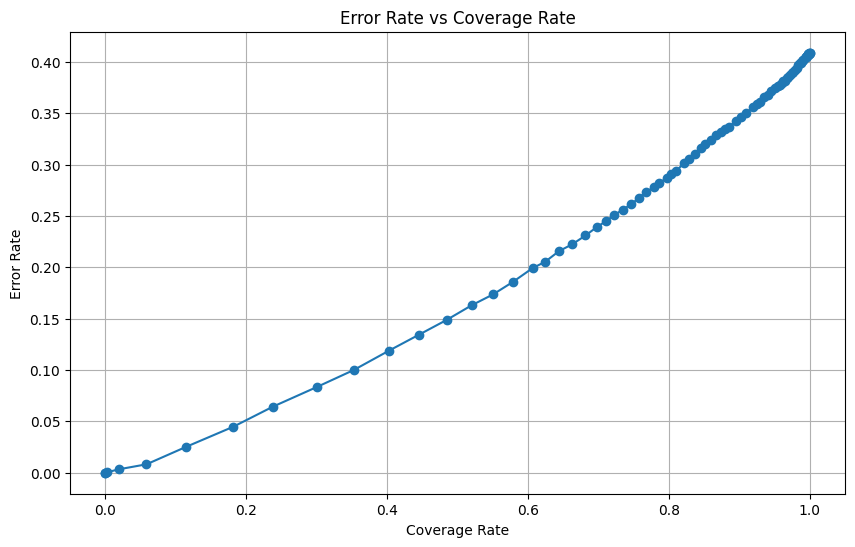

In [21]:
# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(list(error_rate_dict.keys()), list(error_rate_dict.values()), marker='o')
plt.title('Error Rate vs Coverage Rate')
plt.xlabel('Coverage Rate')
plt.ylabel('Error Rate')
plt.grid()
plt.show()

## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

# reload the model from the previous task
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# extract embeddings separately
train_embeddings = []
train_labels = []
for image, label in train_loader:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            train_embeddings.append(model(image).cpu())
            train_labels.append(label[0].cpu())

main_test_loader = DataLoader(main_test_dataset, batch_size=1, shuffle=False)

test_embeddings = []
test_labels = []
for image, label in main_test_loader:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            test_embeddings.append(model(image).cpu())
            test_labels.append(label[0].cpu())

# combine and apply PCA to the full space
all_embeddings = torch.cat(train_embeddings + test_embeddings)
pca = PCA(n_components=2)
all_embeddings_pca = pca.fit_transform(all_embeddings.numpy())

# split back into train and test PCA projections
n_train = len(train_embeddings)
train_embeddings_pca = all_embeddings_pca[:n_train]
test_embeddings_pca = all_embeddings_pca[n_train:]

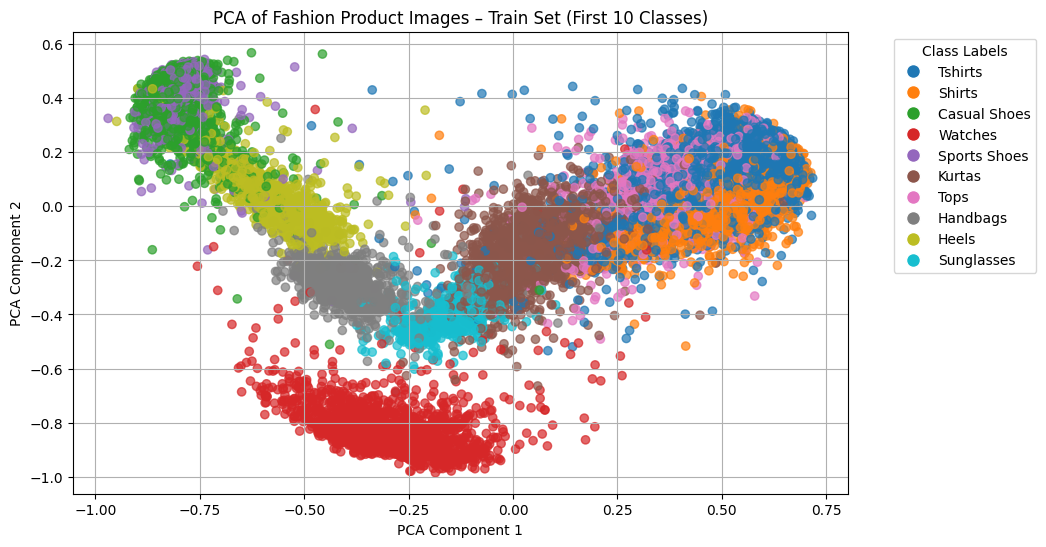

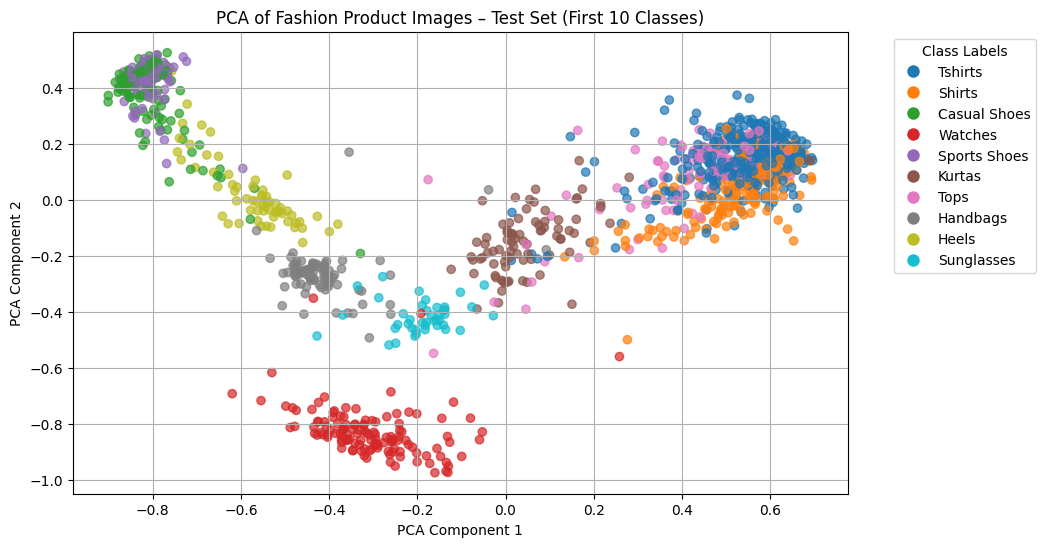

In [57]:
# Define a categorical colormap
cmap = ListedColormap(plt.cm.tab10.colors[:10])  # Use the first 10 colors from the tab10 colormap

# Plot 1: Train Set
plt.figure(figsize=(10, 6))
scatter_train = plt.scatter(
    train_embeddings_pca[:, 0], train_embeddings_pca[:, 1],
    c=train_labels, cmap=cmap, alpha=0.7
)

# Add legend
legend_labels = [label_id_to_label_name[i] for i in range(10)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(10)]
plt.legend(handles, legend_labels, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('PCA of Fashion Product Images – Train Set (First 10 Classes)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Plot 2: Test Set
plt.figure(figsize=(10, 6))
scatter_test = plt.scatter(
    test_embeddings_pca[:, 0], test_embeddings_pca[:, 1],
    c=test_labels, cmap=cmap, alpha=0.7
)

# Reuse legend
plt.legend(handles, legend_labels, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('PCA of Fashion Product Images – Test Set (First 10 Classes)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()


In [58]:
# create a confusion matrix with the first 10 classes over main_test_dataset and main_support_dataset
test_loader_main_test = DataLoader(main_test_dataset, batch_size=1, shuffle=False)
support_loader_main_support = DataLoader(main_support_dataset, batch_size=1, shuffle=False)

# Extract embeddings
test_embeddings_main_test = []
test_labels_main_test = []
for image, label in test_loader_main_test:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            test_embeddings_main_test.append(model(image).cpu())
            test_labels_main_test.append(label[0].cpu())

support_embeddings_main_train = []
support_labels_main_train = []
for image, label in support_loader_main_support:
    if label[0] in range(10):
        image = image.to(device)
        with torch.no_grad():
            support_embeddings_main_train.append(model(image).cpu())
            support_labels_main_train.append(label[0].cpu())

support_embeddings_main_train = torch.cat(support_embeddings_main_train)

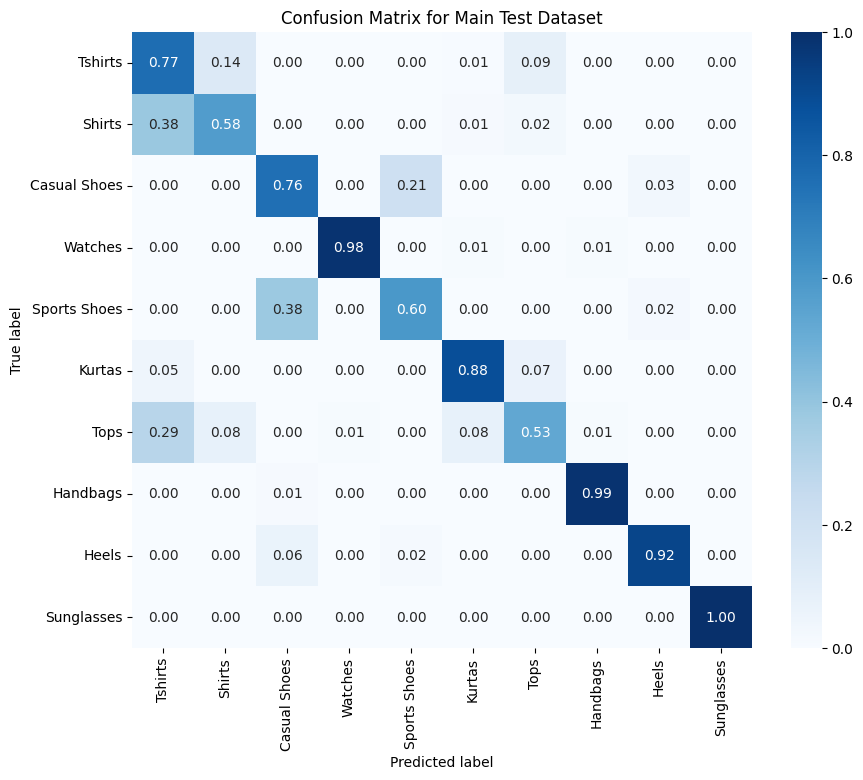

In [59]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(
        y_true, y_pred, labels=classes
    )

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=[label_id_to_label_name[i] for i in classes], 
                yticklabels=[label_id_to_label_name[i] for i in classes])
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

pred_labels = []
for test_embedding in test_embeddings_main_test:
    distances = torch.cdist(test_embedding, support_embeddings_main_train)
    knn_indices = distances.squeeze(0).topk(3, largest=False, dim=0).indices[0]  # Get indices of 3 nearest neighbors
    knn_labels = torch.tensor(support_labels_main_train)[knn_indices]
    predicted_label = torch.mode(knn_labels).values
    pred_labels.append(predicted_label.item())

plot_confusion_matrix(test_labels_main_test, pred_labels, classes=range(10), title='Confusion Matrix for Main Test Dataset')

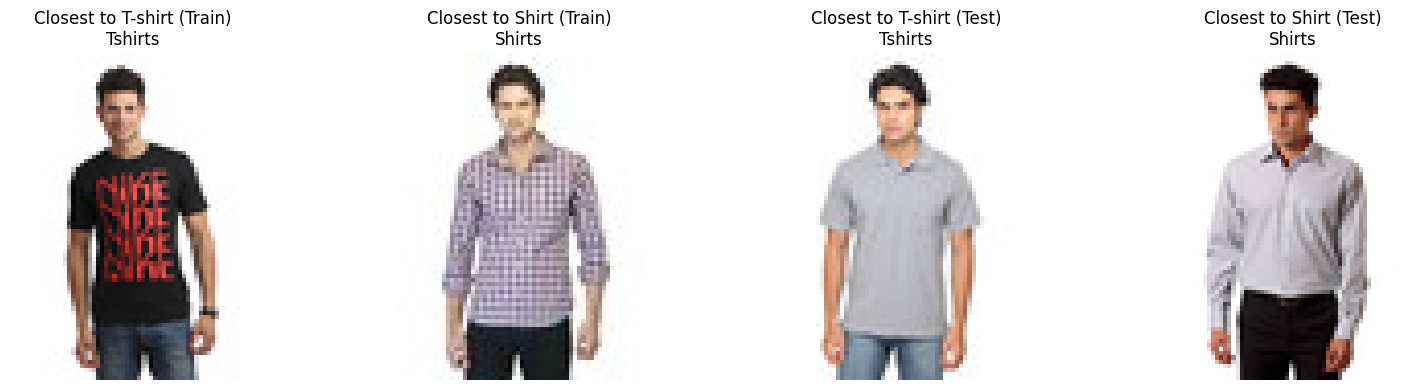

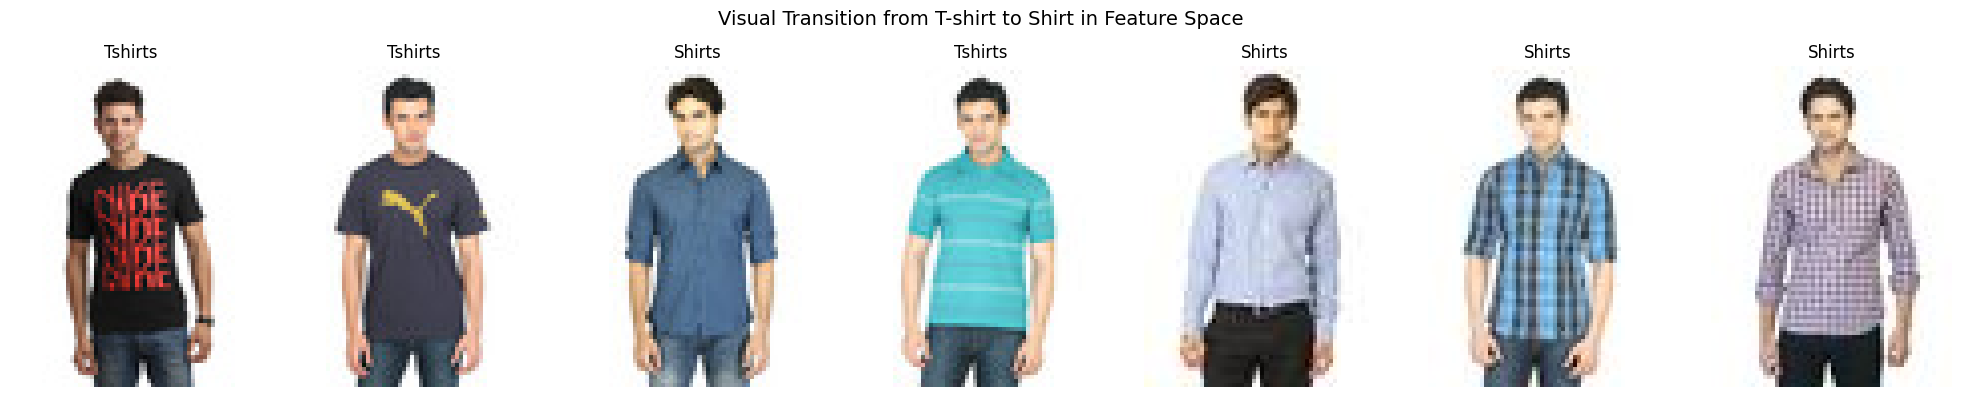

In [62]:
# IDs
tshirt_id = 0
shirt_id = 1

# Get embeddings with index mapping
def get_embeddings_from_dataset(dataset):
    all_embeddings = []
    all_labels = []
    all_indices = []
    for idx, (image, label) in enumerate(DataLoader(dataset, batch_size=1, shuffle=False)):
        image = image.to(device)
        with torch.no_grad():
            embedding = model(image).cpu().squeeze(0)
        all_embeddings.append(embedding)
        all_labels.append(label.item())
        all_indices.append(idx)
    return torch.stack(all_embeddings), torch.tensor(all_labels), all_indices

# Get train/test embeddings
train_embeddings, train_labels, train_indices = get_embeddings_from_dataset(train_dataset)
test_embeddings, test_labels, test_indices = get_embeddings_from_dataset(main_test_dataset)

# Compute centroids
centroid_tshirt_train = train_embeddings[train_labels == tshirt_id].mean(dim=0)
centroid_shirt_train  = train_embeddings[train_labels == shirt_id].mean(dim=0)
centroid_tshirt_test  = test_embeddings[test_labels == tshirt_id].mean(dim=0)
centroid_shirt_test   = test_embeddings[test_labels == shirt_id].mean(dim=0)

# Closest to centroids
def find_closest_sample(coordinate, all_embeddings):
    distances = torch.norm(all_embeddings - coordinate, dim=1)
    return torch.argmin(distances).item()

# get closest indices in embedding array
idx_tshirt_train = find_closest_sample(centroid_tshirt_train, train_embeddings)
idx_shirt_train  = find_closest_sample(centroid_shirt_train,  train_embeddings)
idx_tshirt_test  = find_closest_sample(centroid_tshirt_test,  test_embeddings)
idx_shirt_test   = find_closest_sample(centroid_shirt_test,   test_embeddings)

# map to dataset index
dataset_idx_tshirt_train = train_indices[idx_tshirt_train]
dataset_idx_shirt_train  = train_indices[idx_shirt_train]
dataset_idx_tshirt_test  = test_indices[idx_tshirt_test]
dataset_idx_shirt_test   = test_indices[idx_shirt_test]

# Plotting helper
def plot_image_from_dataset(dataset, index, title, ax):
    image_id = dataset.df.iloc[index]["imageId"]
    label_name = dataset.df.iloc[index]["articleTypeName"]
    image = Image.open(os.path.join(img_dir, f"{image_id}.jpg")).convert("RGB")
    ax.imshow(image)
    ax.set_title(f"{title}\n{label_name}")
    ax.axis("off")

# Plot closest to centroids
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
plot_image_from_dataset(train_dataset, dataset_idx_tshirt_train, "Closest to T-shirt (Train)", axes[0])
plot_image_from_dataset(train_dataset, dataset_idx_shirt_train, "Closest to Shirt (Train)", axes[1])
plot_image_from_dataset(main_test_dataset, dataset_idx_tshirt_test, "Closest to T-shirt (Test)", axes[2])
plot_image_from_dataset(main_test_dataset, dataset_idx_shirt_test, "Closest to Shirt (Test)", axes[3])
plt.tight_layout()
plt.show()

# Transition samples
def get_n_samples_between_two_centroids(centroid1, centroid2, all_embeddings, n=6):
    step_vector = (centroid2 - centroid1) / (n - 1)
    samples = []
    for i in range(n):
        coord = centroid1 + i * step_vector
        closest_idx = find_closest_sample(coord, all_embeddings)
        samples.append(closest_idx)
    return samples

transition_indices = get_n_samples_between_two_centroids(centroid_tshirt_train, centroid_shirt_train, train_embeddings, n=7)
dataset_transition_indices = [train_indices[i] for i in transition_indices]

# 8. Plot transition
fig, axes = plt.subplots(1, len(dataset_transition_indices), figsize=(20, 4))
for ax, idx in zip(axes, dataset_transition_indices):
    plot_image_from_dataset(train_dataset, idx, "", ax)
plt.suptitle("Visual Transition from T-shirt to Shirt in Feature Space", fontsize=14)
plt.tight_layout()
plt.show()



In [20]:
#step 4

# datasets with categories
train_dataset_cat = FashionDataset("dataset/train.csv",img_dir,column_class="categoryId",transform=transform)
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
new_test_dataset_cat =  FashionDataset("dataset/new_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)
new_support_dataset_cat =  FashionDataset("dataset/new_support.csv",img_dir,column_class="categoryId",transform=transform)
merged_test_dataset_cat =  FashionDataset("dataset/merged_test.csv",img_dir,column_class="categoryId",transform=transform)
merged_support_dataset_cat =  FashionDataset("dataset/merged_support.csv",img_dir,column_class="categoryId",transform=transform)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# reload the model from the previous task
model = EmbeddingFashionCNN(embedding_dim=39)
model.load_state_dict(torch.load("task_2.pth"))
model.to(device)


support_loader_main_train_cat = DataLoader(train_dataset_cat, batch_size=32, shuffle=False)
test_loader_main_test_cat = DataLoader(main_test_dataset_cat, batch_size=32, shuffle=False)

support_loader_main_support_cat = DataLoader(main_support_dataset_cat, batch_size=32, shuffle=False)
test_loader_main_test2_cat = DataLoader(main_test_dataset_cat, batch_size=32, shuffle=False)

support_loader_new_cat = DataLoader(new_support_dataset_cat, batch_size=32, shuffle=False)
test_loader_new_cat = DataLoader(new_test_dataset_cat, batch_size=32, shuffle=False)

support_loader_mixed_cat = DataLoader(merged_support_dataset_cat, batch_size=32, shuffle=False)
test_loader_mixed_cat = DataLoader(merged_test_dataset_cat, batch_size=32, shuffle=False)


In [50]:
support_embeddings_main_train_cat, support_labels_main_train_cat = extract_embeddings(model, support_loader_main_train_cat, device)
test_embeddings_main_test_cat, test_labels_main_test_cat = extract_embeddings(model, test_loader_main_test_cat, device)

support_embeddings_main_support_cat, support_labels_main_support_cat = extract_embeddings(model, support_loader_main_support_cat, device)
test_embeddings_main_test2_cat, test_labels_main_test2_cat = extract_embeddings(model, test_loader_main_test2_cat, device)

support_embeddings_new_cat, support_labels_new_cat = extract_embeddings(model, support_loader_new_cat, device)
test_embeddings_new_cat, test_labels_new_cat = extract_embeddings(model, test_loader_new_cat, device)

support_embeddings_mixed_cat, support_labels_mixed_cat = extract_embeddings(model, support_loader_mixed_cat, device)
test_embeddings_mixed_cat, test_labels_mixed_cat = extract_embeddings(model, test_loader_mixed_cat, device)


In [51]:
def evaluate_knn(support_embeddings, support_labels, test_embeddings, test_labels, k=5):
    predicted_labels = knn_classify(test_embeddings, support_embeddings, support_labels, k=k)

    accuracy = (predicted_labels == test_labels).float().mean().item()
    balanced_acc = balanced_accuracy_score(test_labels.numpy(), predicted_labels.numpy())

    return accuracy, balanced_acc

# Scenario 1 (Category-level): Main classes train -> Main classes test
acc1_cat, bal_acc1_cat = evaluate_knn(support_embeddings_main_train_cat, support_labels_main_train_cat,
                                      test_embeddings_main_test_cat, test_labels_main_test_cat)
print(f'Scenario 1 (Category) - Accuracy: {acc1_cat:.4f} | Balanced Accuracy: {bal_acc1_cat:.4f}')

# Scenario 2 (Category-level): Main classes support -> Main classes test
acc2_cat, bal_acc2_cat = evaluate_knn(support_embeddings_main_support_cat, support_labels_main_support_cat,
                                      test_embeddings_main_test2_cat, test_labels_main_test2_cat)
print(f'Scenario 2 (Category) - Accuracy: {acc2_cat:.4f} | Balanced Accuracy: {bal_acc2_cat:.4f}')

# Scenario 3 (Category-level): New classes support -> New classes test
acc3_cat, bal_acc3_cat = evaluate_knn(support_embeddings_new_cat, support_labels_new_cat,
                                      test_embeddings_new_cat, test_labels_new_cat)
print(f'Scenario 3 (Category) - Accuracy: {acc3_cat:.4f} | Balanced Accuracy: {bal_acc3_cat:.4f}')

# Scenario 4 (Category-level): Mixed support -> Mixed test
acc4_cat, bal_acc4_cat = evaluate_knn(support_embeddings_mixed_cat, support_labels_mixed_cat,
                                      test_embeddings_mixed_cat, test_labels_mixed_cat)
print(f'Scenario 4 (Category) - Accuracy: {acc4_cat:.4f} | Balanced Accuracy: {bal_acc4_cat:.4f}')

Scenario 1 (Category) - Accuracy: 0.9544 | Balanced Accuracy: 0.9230
Scenario 2 (Category) - Accuracy: 0.9489 | Balanced Accuracy: 0.9213
Scenario 3 (Category) - Accuracy: 0.7518 | Balanced Accuracy: 0.6978
Scenario 4 (Category) - Accuracy: 0.8283 | Balanced Accuracy: 0.7492
